In [33]:
import matplotlib
%matplotlib inline
from matplotlib.colors import LogNorm
import yt

In [34]:
from SZmaps.IO import get_fits_data as gf
reload(gf)
yt_datastruct = gf.create_yt_datastruc_from_cubes('/home/babyostrich/data/L500_fits/','1.0005',1, 6)
dd = yt_datastruct.all_data()

yt : [INFO     ] 2017-06-27 13:40:43,466 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-27 13:40:43,467 Parameters: domain_dimensions         = [ 256.  256.  256.]
yt : [INFO     ] 2017-06-27 13:40:43,468 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-06-27 13:40:43,469 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-06-27 13:40:43,470 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2017-06-27 13:40:45,144 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 13:40:45,145 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 13:40:45,147 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 13:40:45,148 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 13:40:45,149 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2017-06-27 13:40:45,206 Making a fixed resolution buffer of (('gas', 'szy')) 800 by 800
yt : [INFO     ] 2017-06-27 13:40:45,221 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2017-06-27 13:40:45,237 Making a fixed resolution buffer of (('gas', 'velocity_x')) 800 by 800
yt : [WARNING  ] 2017-06-27 13:40:45,722 Plot image for field ('gas', 'velocity_x') has both positive and negative values. Min = -95750225.560025, Max = 122563083.571931.
yt : [WARNING  ] 2017-06-27 13:40:45,723 Switching to symlog colorbar scaling unless linear scaling is specified later
yt : [I

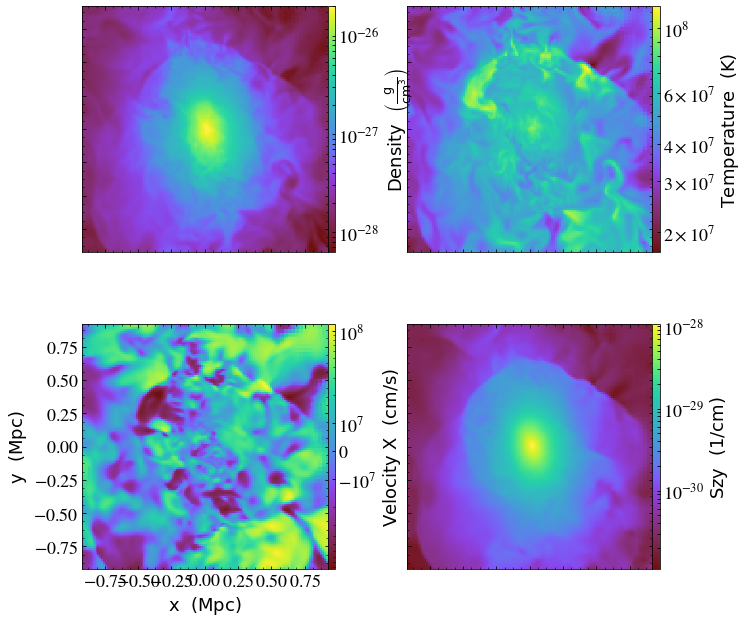

In [35]:
# Test datastructure: multi-plot projection of T, rho, SZ, and velocity
# http://yt-project.org/doc/cookbook/complex_plots.html
import yt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (2, 2),
                axes_pad = 1.0,
                label_mode = "1",
                share_all = True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")

fields = ['density', 'temperature', 'velocity_x', 'szy']

# Create the plot.  Since SlicePlot accepts a list of fields, we need only
# do this once.
p = yt.SlicePlot(yt_datastruct, 'z', fields)

p.zoom(2)

# For each plotted field, force the SlicePlot to redraw itself onto the AxesGrid
# axes.
for i, field in enumerate(fields):
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]

# Finally, redraw the plot on the AxesGrid axes.
p._setup_plots()

In [72]:
# Test reading in database, using database to delineate the r500c, r200m borders
# NOTE: !!!! Need 200c values
import SZmaps.IO.database as db
from yt.units import kpc
halo_ids = db.sim.get_halo_ids()
halo_props = db.collect_halo_props(halo_ids)
r200m = halo_props['r200m'][0] 
r500c = halo_props['r500c'][0] 

Annotate projections, and calculate integrated quantities in sphere and cylinder along all lines of sight.

yt : [INFO     ] 2017-06-27 13:55:56,494 Projection completed
yt : [INFO     ] 2017-06-27 13:55:56,495 xlim = 0.025282 0.974718
yt : [INFO     ] 2017-06-27 13:55:56,496 ylim = 0.025282 0.974718
yt : [INFO     ] 2017-06-27 13:55:56,498 xlim = 0.025282 0.974718
yt : [INFO     ] 2017-06-27 13:55:56,499 ylim = 0.025282 0.974718
yt : [INFO     ] 2017-06-27 13:55:56,500 Making a fixed resolution buffer of (('gas', 'szy')) 800 by 800



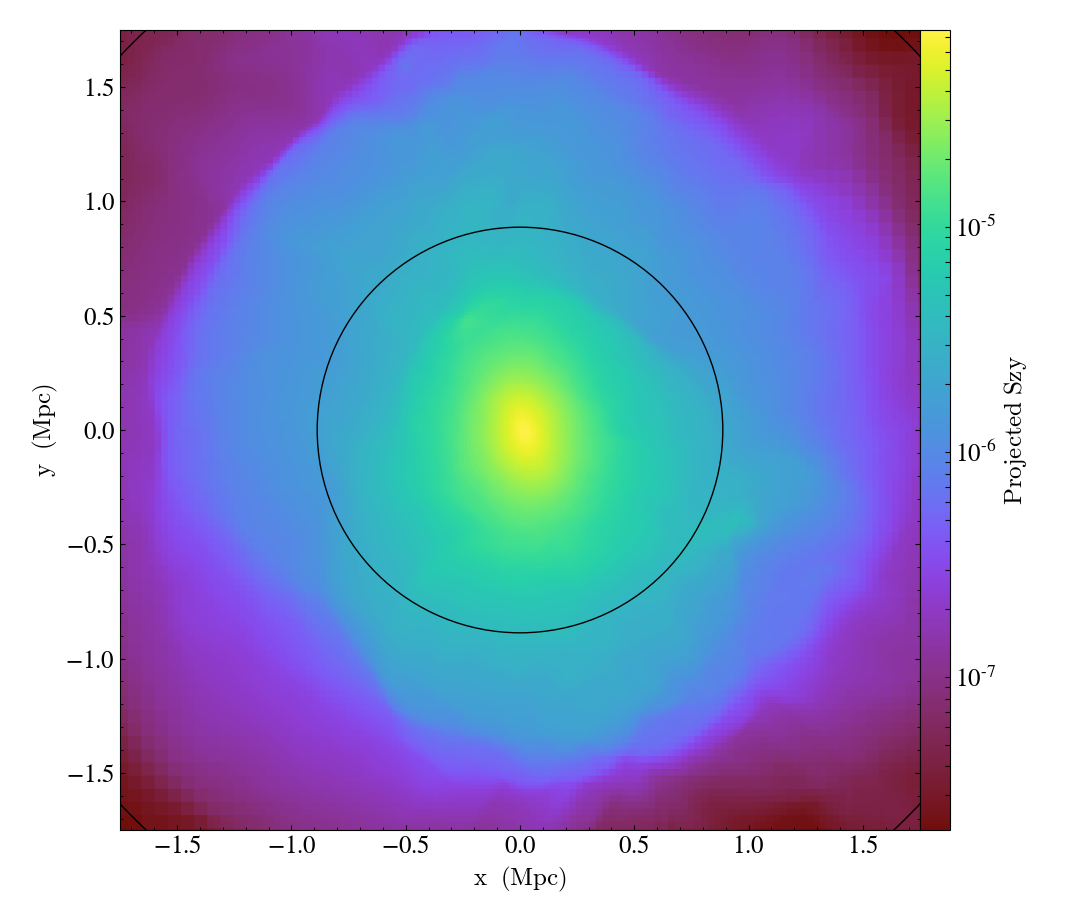

In [73]:
from yt.units import Mpc
axis = 2
p = yt.ProjectionPlot(yt_datastruct, axis, 'szy', width=3.5*Mpc)
p.annotate_sphere([0.5, 0.5, 0.5], radius=(r500c, 'kpc'),
                  circle_args={'color':'black'})
p.annotate_sphere([0.5, 0.5, 0.5], radius=(r200m, 'kpc'),
                  circle_args={'color':'black'})

Let's calculate the angular diameter distance for a cluster that sits at observational redshift of zf = 0.02.

In [74]:
from yt.utilities.cosmology import Cosmology
cosmo = Cosmology()
(zi, zf) = (0,0.02)
dA = cosmo.angular_diameter_distance(zi,zf).in_units('Mpc')

Next, let's integrate in a sphere and in a cylinder, plot in each direction, and plot.
Sphere: http://yt-project.org/doc/reference/api/generated/yt.data_objects.selection_data_containers.YTSphere.html#yt.data_objects.selection_data_containers.YTSphere


In [75]:
sphere = yt_datastruct.sphere([0.5,0.5,0.5],(r500c,'kpc'))
sphere.volume().in_units('Mpc**3') * sphere['szy'].sum().in_units('1/Mpc') / dA**2 

0.00276568147789 dimensionless

Cylinder: http://yt-project.org/doc/reference/api/generated/yt.data_objects.selection_data_containers.YTDisk.html#yt.data_objects.selection_data_containers.YTDisk

In [77]:
center = [0.5]*3
normal = [1,0,0]
radius = r500c
depth = 3.*r500c
cylinder = yt_datastruct.disk(center, normal, (radius,'kpc'), (depth, 'kpc'))
cylinder.volume().in_units('Mpc**3') * cylinder['szy'].sum().in_units('1/Mpc') / dA**2

0.0100367555026 dimensionless

To do:

(1)  Script up the loading and sphere calculation of a halo.  Done. 

(2)  Integrate the r500c quantity in determining the sphere's extent. Done.

(3)  Make a Ysz vs. mass plot. Done.

(4)  Do (1)-(3) for a cylinder.

(5)  Do the same thing for outskirt annuli or outskirt shells - this should basically just pick up the scatter from the Ysz vs. mass scaling.

In [66]:
import pandas as pd
szy_df = pd.read_csv('/home/babyostrich/Repos/SZmaps/calculate_scaling/szyscaling.csv',sep=' ')

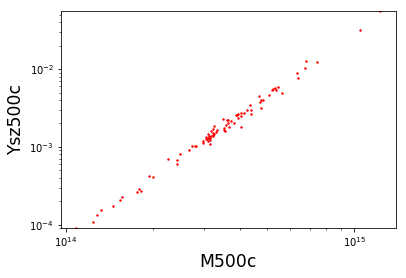

In [67]:
# Scatter plot of spherically integrated Ysz
plt.scatter(szy_df['M500c'],szy_df['Ysz500c'],s=2.,c='r')
plt.xscale('log')
plt.yscale('log')
plt.ylim((szy_df['Ysz500c'].min(),szy_df['Ysz500c'].max()) )
plt.ylabel('Ysz500c',fontsize='xx-large')
plt.xlabel('M500c',fontsize='xx-large')

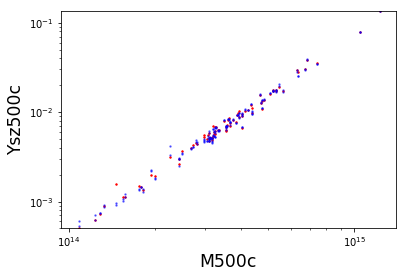

In [82]:
# Scatter plot of cylindrically integrated Ysz
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_x'],s=2.,c='r')
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_y'],s=2.,c='b',alpha=0.5)
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_z'],s=2.,c='b',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim((szy_df['Yszcyl_x'].min(),szy_df['Yszcyl_x'].max()) )
plt.ylabel('Ysz500c',fontsize='xx-large')
plt.xlabel('M500c',fontsize='xx-large')